#**$Introduction$**


 
$Project Name:$ Predicting COVID-19 Hospitalizations using Kalman Filter

$Team$ $Members:$ Nitharsan Sivakanthan , Pooja Bhatia

$Problem$ $Statement:$ We want to predict COVID-19 Hospitalizations in Washington State using Kalman filter on the basis of various predictors (positive cases, vaccinations, Age, Cases per county). The Kalman filter is typically used for time series data. We plan to use daily/weekly COVID-19 data to predict hospitalizations. 

In research papers we found, there was promise in using the Kalman filter for time series forecasting to determine trends in the COVID-19 pandemic. These papers also included a possibility in studying the association of vaccinated people and number of daily cases for predictions.



# **$Implementatin$ $of$ $Kalman$ $filter$ $for$ $predecting$ $Hospitalizations$ $due$ $to$ COVID-19 $using$ $Python$**

Importing all libraries


In [1]:
!pip install pykalman -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import stats, special
import seaborn as sns 
sns.set_style("whitegrid")
from numpy.linalg import inv
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Preparation

We are sourcing the data from Washington State Department of Health. 
There are 4 datasets. 
1. Number of cases 
2. Number of vaccinations
3. Number of deaths
4. Number of hosptilazations
All the datasets have daily reported cummulative count.


In [3]:
# create dataframes from CSV's
cases = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative_Cases.csv')
vac = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Vaccinations.csv')
death = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Deaths.csv')
hosp = pd.read_csv('https://raw.githubusercontent.com/poojabhatia17dec/Covid19-hospitalisation-prediction--Kalman-Flter/main/Cumulative__Hospitalizations.csv')

The 4 datasets above are now joined on date to convert into a single table (dataframe).

In [4]:
# combine into one dataframe
Covid_data = hosp.join(cases.set_index('Date'), on='Date').join(vac.set_index('Date'), on='Date').join(death.set_index('Date'), on='Date')

Displaying top 15 rows to verify the format of dataset. 

In [5]:
Covid_data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths
0,2/25/2020,1092,0,1,NaN,2
1,2/26/2020,1094,0,1,NaN,4
2,2/27/2020,1105,0,1,NaN,4
3,2/28/2020,1114,0,1,NaN,6
4,2/29/2020,1121,0,1,NaN,7
5,3/1/2020,1129,0,1,NaN,10
6,3/2/2020,1150,13,14,NaN,13
7,3/3/2020,1162,16,30,NaN,16
8,3/4/2020,1176,15,45,NaN,18
9,3/5/2020,1203,21,66,NaN,23


Since, we have daily number of cases in our dataset, but we do not have daily numbers for hospitalization, vaccines and death, we are computing the numbers using diff function. It calculates the difference in previous and current row. 

In [6]:
# create columns for daily counts, cases already has one
Covid_data['Hospitalizations_Daily'] = Covid_data['Hospitalizations'].diff()
Covid_data['Vaccines_Daily'] = Covid_data['Vaccines'].diff()
Covid_data['Deaths_Daily'] = Covid_data['Deaths'].diff()

Introducting a time column to generate the number of days since Covid-19 started.

In [7]:
# add a time column
Covid_data['Time'] = np.arange(len(Covid_data.index))

Displaying the information of Covid_data table.

In [8]:
# check NA values do to nature of data can set NA values to 0
Covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    703 non-null    object 
 1   Hospitalizations        703 non-null    int64  
 2   New Cases Reported      703 non-null    int64  
 3   Cases                   703 non-null    int64  
 4   Vaccines                407 non-null    float64
 5   Deaths                  703 non-null    int64  
 6   Hospitalizations_Daily  702 non-null    float64
 7   Vaccines_Daily          406 non-null    float64
 8   Deaths_Daily            702 non-null    float64
 9   Time                    703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


From above we see that there are nulls in few columns, filling in the null using fill.na().


In [9]:
Covid_data = Covid_data.fillna(0)
Covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    703 non-null    object 
 1   Hospitalizations        703 non-null    int64  
 2   New Cases Reported      703 non-null    int64  
 3   Cases                   703 non-null    int64  
 4   Vaccines                703 non-null    float64
 5   Deaths                  703 non-null    int64  
 6   Hospitalizations_Daily  703 non-null    float64
 7   Vaccines_Daily          703 non-null    float64
 8   Deaths_Daily            703 non-null    float64
 9   Time                    703 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 55.0+ KB


In [10]:
Covid_data.head(15)

,Date,Hospitalizations,New Cases Reported,Cases,Vaccines,Deaths,Hospitalizations_Daily,Vaccines_Daily,Deaths_Daily,Time
0,2/25/2020,1092,0,1,0.0,2,0.0,0.0,0.0,0
1,2/26/2020,1094,0,1,0.0,4,2.0,0.0,2.0,1
2,2/27/2020,1105,0,1,0.0,4,11.0,0.0,0.0,2
3,2/28/2020,1114,0,1,0.0,6,9.0,0.0,2.0,3
4,2/29/2020,1121,0,1,0.0,7,7.0,0.0,1.0,4
5,3/1/2020,1129,0,1,0.0,10,8.0,0.0,3.0,5
6,3/2/2020,1150,13,14,0.0,13,21.0,0.0,3.0,6
7,3/3/2020,1162,16,30,0.0,16,12.0,0.0,3.0,7
8,3/4/2020,1176,15,45,0.0,18,14.0,0.0,2.0,8
9,3/5/2020,1203,21,66,0.0,23,27.0,0.0,5.0,9


We now have the data in the required form for further analysis.

# Data Exploration

## Plots of variables over time
Scatterplot of number of hospitalizations reported daily

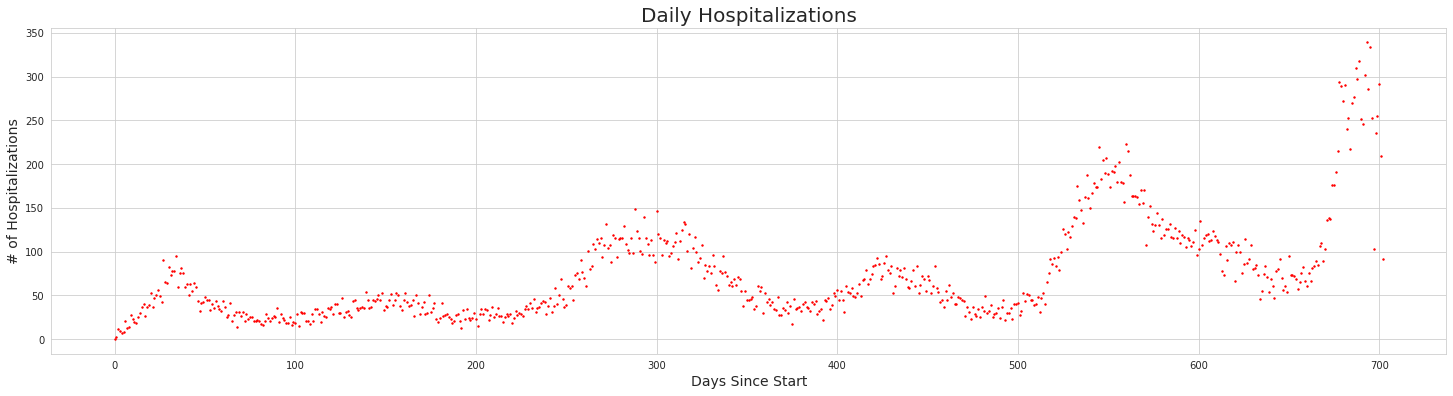

In [11]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['Hospitalizations_Daily'], color='red', s = 2)
plt.title('Daily Hospitalizations', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of number of cases reported daily

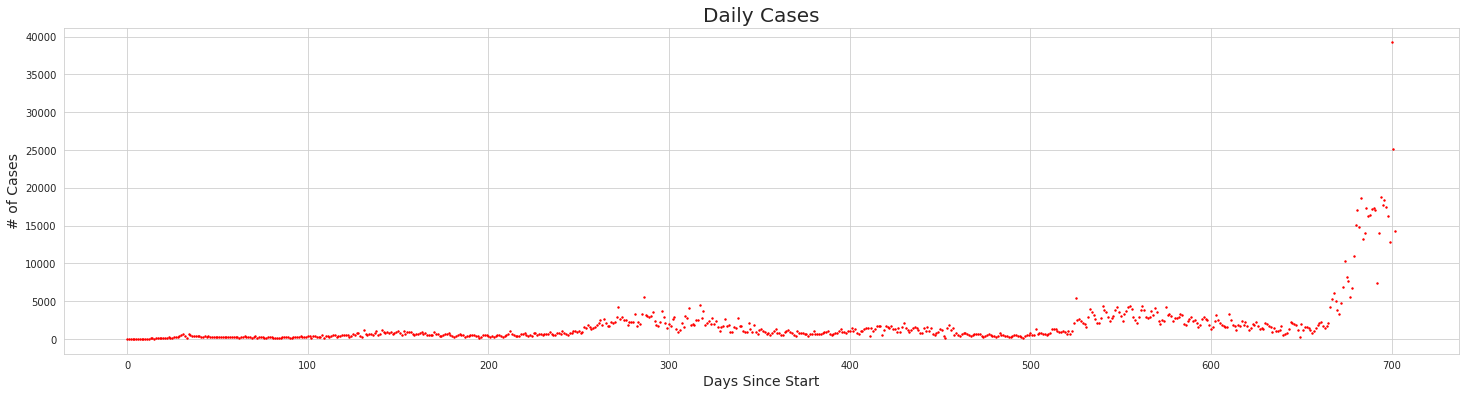

In [12]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['New Cases Reported'], color='red', s= 2)
plt.title('Daily Cases', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Cases', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of number of deaths reported daily

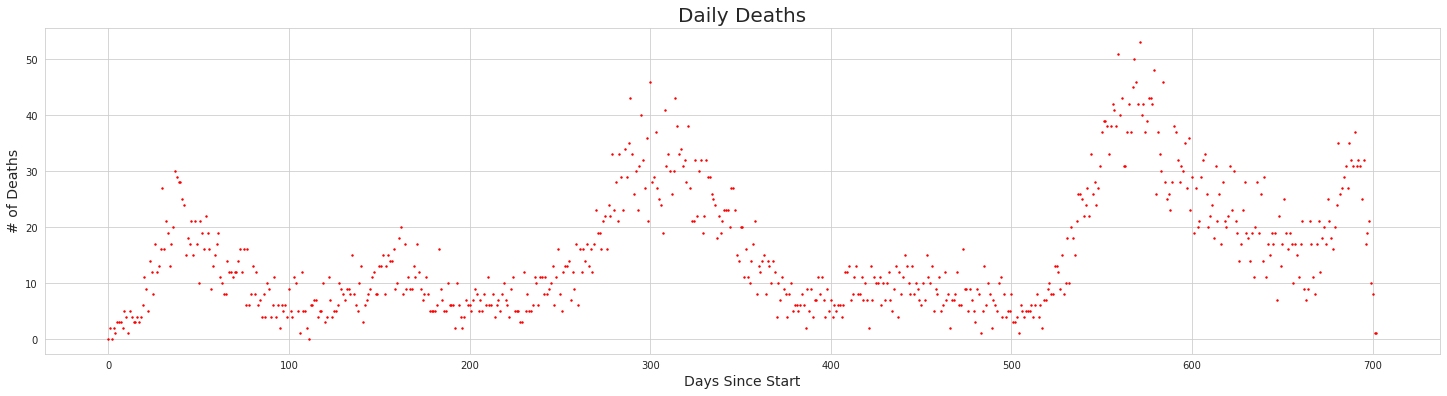

In [13]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['Deaths_Daily'], color='red', s = 2)
plt.title('Daily Deaths', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Deaths', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of number of Vaccinations reported daily

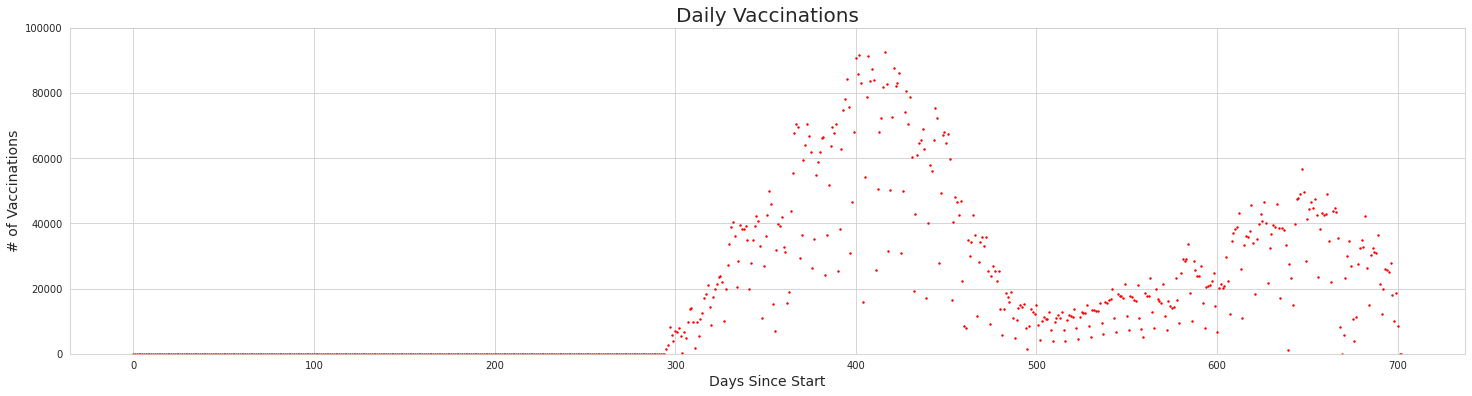

In [14]:
plt.figure(figsize=(25,6))
plt.scatter(Covid_data['Time'], Covid_data['Vaccines_Daily'], color='red', s = 2)
plt.title('Daily Vaccinations', fontsize=20)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Vaccinations', fontsize=14)
plt.grid(True)
plt.ylim(0,100000)
plt.show()

## Multiple Linear Regression

###Fitting Multiple linear regression to our data to see how it fits.

Spliting the dataset into Train(80%) and Test(20%) data.

In [15]:
X = Covid_data[['New Cases Reported','Deaths_Daily','Vaccines_Daily','Time']]
Y = Covid_data[['Hospitalizations_Daily']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

Creating a linear model on training data to generate intercept and coefficients.

In [16]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [4.37935618]
Coefficients: 
 [[ 1.01510043e-02  2.17099015e+00 -7.51350897e-05  5.54719773e-02]]


Training score:

In [17]:
print("Training Score: " ,round(reg.score(x_train,y_train)*100,1), "%")

Training Score:  82.7 %


Testing Score:

In [18]:
print("Testing Score: " ,round(reg.score(x_test,y_test)*100,1), "%")

Testing Score:  76.0 %


Fetching the residuals

In [19]:
y_predicted = reg.predict(x_test)
resid = y_test - y_predicted

Scatterplot of Residuals 

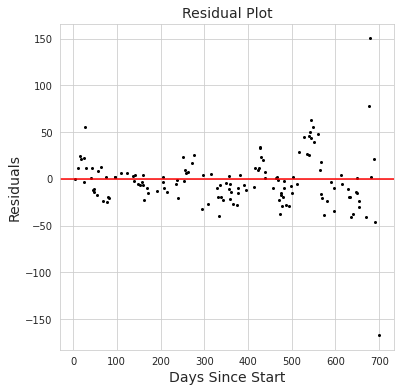

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], resid, color='black', s= 4)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(True)
plt.show()

Scatterplot of predicted daily hospitalizations versus reported daily hospitalizations:

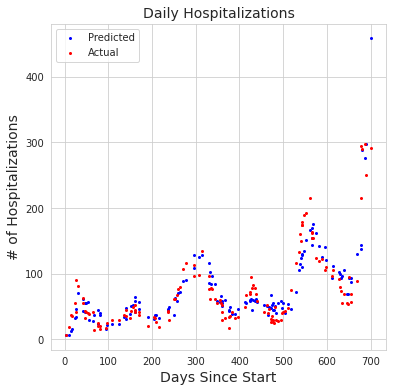

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(x_test['Time'], reg.predict(x_test), color='blue', s= 4)
plt.scatter(x_test['Time'], y_test['Hospitalizations_Daily'], color = 'red', s =4)
plt.legend(['Predicted','Actual'])
plt.title('Daily Hospitalizations', fontsize=14)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('# of Hospitalizations', fontsize=14)
plt.grid(True)
plt.show()

Multiple linear Regression does fairly well at predicting Hospitalizations. We will try to model the relationship better using the Kalman Filter.

# Kalman Filter without control signal

We can write our state equations as :
$$\mathbf{x}_{k+1} = A_k\mathbf{x}_{k} + B_k\mathbf{u}_k + \mathbf{w}_k$$
$$\mathbf{y}_k = C_k\mathbf{x}_k + \mathbf{v}_k$$


$$\mathbf{x}_k = \begin{bmatrix}h_k \\ h'_k\end{bmatrix} = \begin{bmatrix}hospitalizations_k \\ hospitalizations'_k\end{bmatrix}$$

\begin{align}
h(t + \Delta t) &= h(t) + \Delta t\space h'(t) + \text{error} \\ \\
\end{align}

\begin{align}
h'(t + \Delta t) &= h'(t) + \Delta t\space h''(t) + \text{error}  \\ \\
&= h'(t)   + \text{error}  
\end{align}

\\

$$\mathbf{x}_{k+1} = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}\mathbf{x}_{k} + \begin{bmatrix}0\\ 0\end{bmatrix}u_{k} + \mathbf{w}_k$$

where $u_{k}$ is not being considered and added to the noise and $\mathbf{w}_k$ is a noise term.

\\
$$y_k = \begin{bmatrix}1 & 0\end{bmatrix}\mathbf{x}_{k} + \mathbf{v}_k$$
where $\mathbf{v}_k$ is a noise term.


In this model, the matrices are constant and given by:

$$A = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}$$

\\

$$B = \begin{bmatrix}0\\ 0\end{bmatrix}$$

\\

$$C = \begin{bmatrix}1 & 0\end{bmatrix}$$

#### Time

Here we create the timesteps to increase by 1 each day.

In [22]:
#Time step
dt = 1

#Number of time steps
n_timesteps = len(Covid_data['Time'])

#Time
t = np.arange(n_timesteps)*dt

#### Matrices

Define the matrices $A$, $B$, and $C$.

In [23]:
A = np.array([[1, dt],
             [0, 1]])

B = np.array([[0],[0]])

C = np.array([[1, 0]])

#Use these matrices to determine the dimensions of the state and observation vectors
n_dim_state = A.shape[0]

n_dim_obs = C.shape[0]

#### Control Signal

Unsure of what the control signal is in this application we will start without one.

Get an array of zeros with proper length

In [24]:
u = np.ones((1,n_timesteps))

In [25]:
b = np.matmul(B,u)

In [26]:
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Noise distributions

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [27]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = [[1000,0.0],[0.0,45]]


Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [28]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = 2810


#### Use the Kalman filter to estimate the states

Create the observations

In [29]:
y = Covid_data['Hospitalizations']

Define a Kalman filter object with the known properties of the system

In [30]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [31]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter:

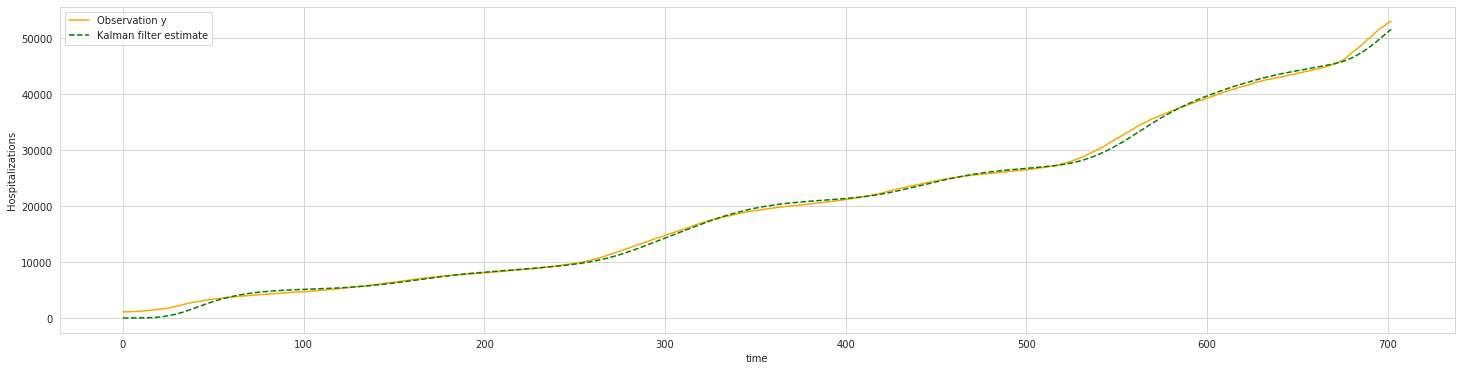

In [32]:
#Plot position
plt.figure(figsize = (25,6))
plt.plot(t,y, color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


It appears the Kalman filter estimates are close to the observations however, there is high error in the estimates.

Plot differences in y and Kalman filter estimate:

Text(0, 0.5, 'Residuals')

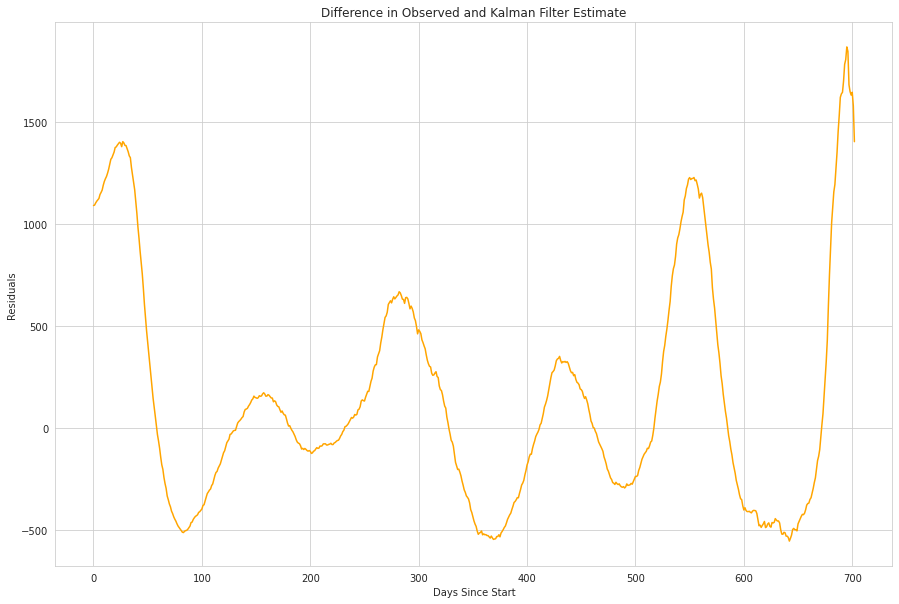

In [33]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

Here we can see the how far our Kalman filter estimates are from the observtions. We are getting estimates within 2000 hospitalizations from the observed values. We will try to improve this.

#### Learning model parameters

Suppose that we only have guesses for the noise covariances.

In [34]:
state_cov_matrix_guess = [[1000,0.0],[0.0,45]]

obs_std_guess = 2810.

We can define a `KalmanFilter` object with the guessed values and indicate that we want to use the EM algorithm to learn those parameters using `em_vars=['transition_covariance', 'observation_covariance']`

In [35]:
kf_learn = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix_guess, observation_covariance=obs_std_guess**2, transition_offsets=b.T, em_vars=['transition_covariance', 'observation_covariance'])

Applying the method `.em` uses the EM algorithm to estimate those parameters based on the observed data.

In [36]:
kf_learn = kf_learn.em(y, n_iter = 10)

Compare the learned values to the true values. This is a difficult optimization problem, so the estimates will not be perfect.

In [37]:
print('EM estimate of state covariance = ', kf_learn.transition_covariance, '. True covariance = ', state_cov_matrix)

EM estimate of state covariance =  [[1971.77474165  143.92924863]
 [ 143.92924863   60.38406785]] . True covariance =  [[1000, 0.0], [0.0, 45]]


In [38]:
print('EM estimate of observation variance = ', kf_learn.observation_covariance, '. True variance = ', obs_std**2)

EM estimate of observation variance =  [[3530.56660864]] . True variance =  7896100


#### Use Estimated values to Update Kalman Filter

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [39]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = kf_learn.transition_covariance


Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [40]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = np.sqrt(kf_learn.observation_covariance)


#### Use the Kalman filter to estimate the states with the estimated optimal parameters

Define a Kalman filter object with the known properties of the system

In [41]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [42]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter:

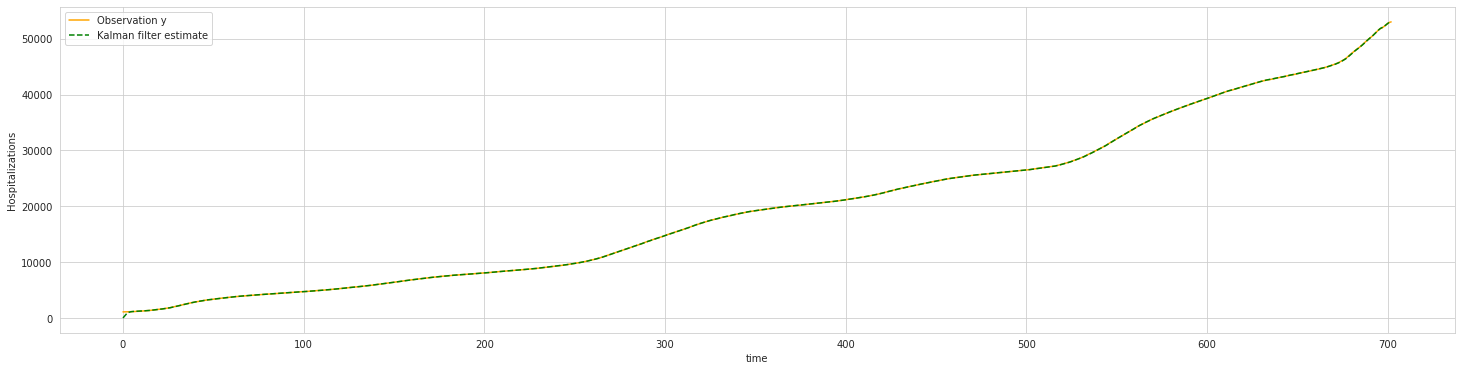

In [43]:
#Plot position
plt.figure(figsize = (25,6))
plt.plot(t,y,color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


We observe that with these optimal parameter estimates, the Kalman filter very quickly is able to obtain estimates near the observed values.

Plot differences in observed values and Kalman filter estimate:

Text(0, 0.5, 'Residuals')

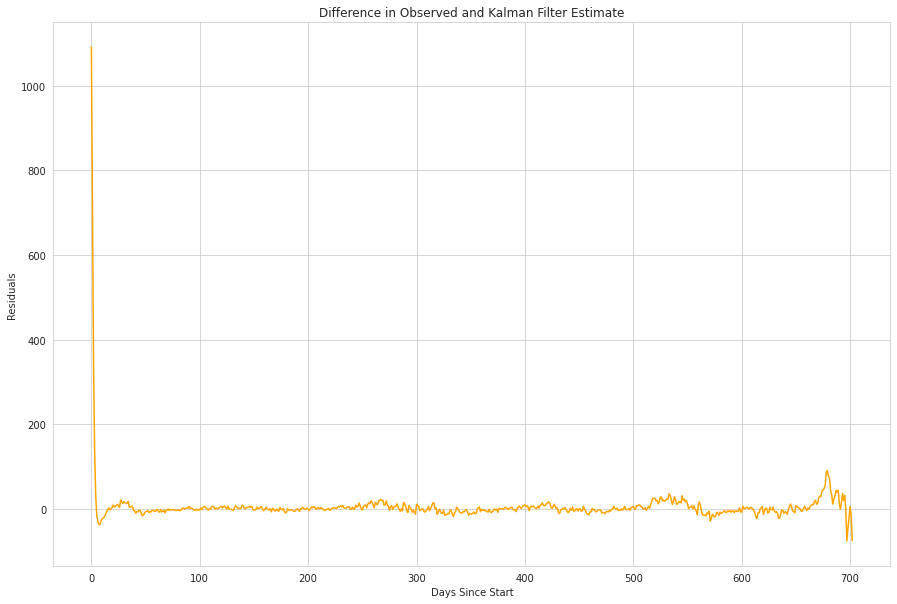

In [44]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

The error in estimates very quickly reduces from over 1000 hospitalizations to within 100 hospitalizations. There is a small peak towards the end of our timeline which could be interesting to investigate further.

Plot differences in observed values and kalman filter estimate zoomed in on later values of time.

(-100.0, 100.0)

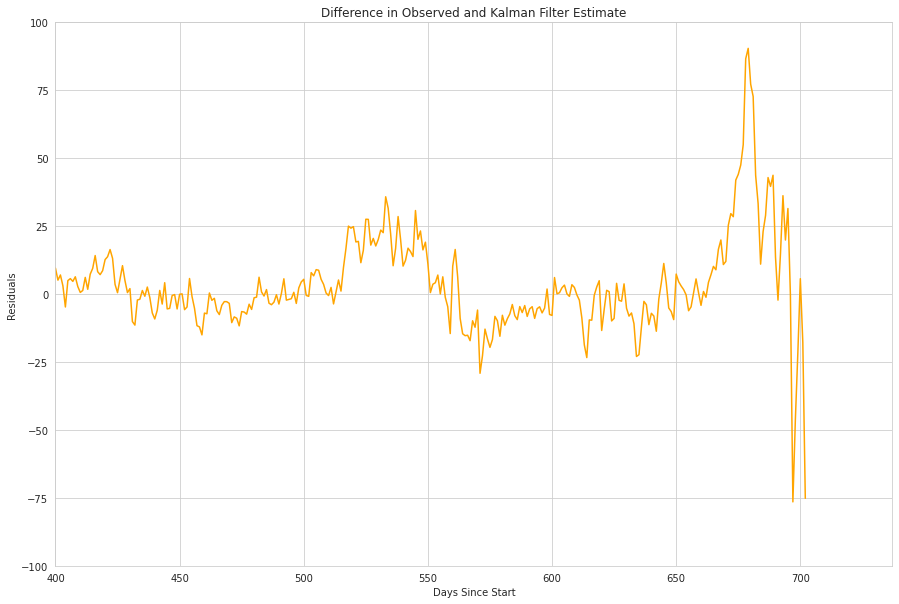

In [45]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')
plt.xlim(400)
plt.ylim(ymin = -100, ymax =100)

Zooming in at the end of the timeline, we can see the errors increase signifcantly compared to previous values, however the kalman filter is still able to estimate true values within 100 hospitalizations every day. 

#### Predict future values

Calculate predictions for the next 10 days.

In [46]:
for n in range(10):
  xhat_prev = filtered_state_means[-1]
  xhat_pred = np.matmul(A,xhat_prev) + b.T[-1]
  filtered_state_means = np.vstack((filtered_state_means, xhat_pred))

Plot the predictions for the next 10 days:

(52000.0, 56000.0)

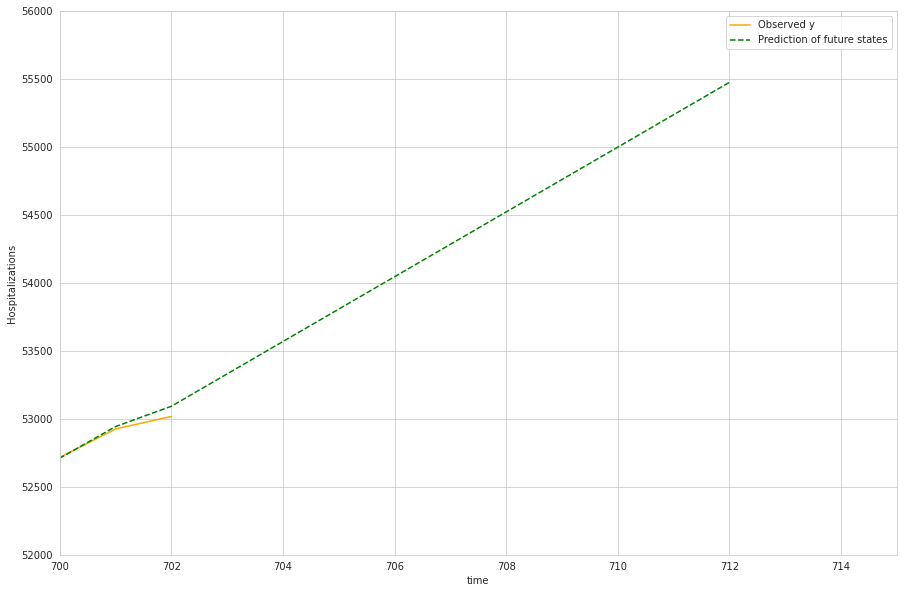

In [47]:
t_pred = np.arange(n_timesteps+10)*dt

#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y,color = 'orange')
plt.plot(t_pred,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observed y','Prediction of future states'])
plt.xlim(xmin = 700, xmax = 715)
plt.ylim(ymin = 52000, ymax =56000)


Without having observed values, the Kalman filter predictions will continue to increase in hospitalizations over time based on the last updated state equation. The farther we extrapolate in time, the less likely we expect these predictions to be true.

# Kalman Filter with control signal estimate

Now we will apply the Kalman Filter to the same model with an estimate of the control signal.

We can write our state equations as :
$$\mathbf{x}_{k+1} = A_k\mathbf{x}_{k} + B_k\mathbf{u}_k + \mathbf{w}_k$$
$$\mathbf{y}_k = C_k\mathbf{x}_k + \mathbf{v}_k$$

$$\mathbf{x}_k = \begin{bmatrix}h_k \\ h'_k\end{bmatrix}$$

\begin{align}
h(t + \Delta t) &= h(t) + \Delta t\space h'(t) + \frac{1}{2}\Delta t^2\space h''(t) + \text{error} \\ \\
\end{align}

\begin{align}
h'(t + \Delta t) &= h'(t) + \Delta t\space h''(t) + \text{error}  \\
\end{align}

\\

$$\mathbf{x}_{k+1} = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}\mathbf{x}_{k} + \begin{bmatrix}\frac{1}{2}\Delta t^2\\ \Delta t\end{bmatrix}u_{k} + \mathbf{w}_k$$

where $u_{k} = h''(t)$ and $\mathbf{w}_k$ is a noise term.

\\
$$y_k = \begin{bmatrix}1 & 0\end{bmatrix}\mathbf{x}_{k} + \mathbf{v}_k$$
where $\mathbf{v}_k$ is a noise term.


In this model, the matrices are constant and given by:

$$A = \begin{bmatrix}1 & \Delta t\\ 0 & 1\end{bmatrix}$$

\\

$$B = \begin{bmatrix}\frac{1}{2}\Delta t^2\\ \Delta t\end{bmatrix}$$

\\

$$C = \begin{bmatrix}1 & 0\end{bmatrix}$$

#### Matrices

Define new matrix $B$.

In [48]:
B = np.array([[.5* dt**2],[dt]])

#### Control Signal

We will estimate the control signal using linear regression, using the slope of the linear regression as the constant control signal.

In [49]:
X = Covid_data[['Time']]
Y = Covid_data[['Hospitalizations_Daily']]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)

In [50]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 [14.48356658]
Coefficients: 
 [[0.17062195]]


Get an array with proper length

In [51]:
u = .175*np.ones((1,n_timesteps))

In [52]:
b = np.matmul(B,u)

In [53]:
b

array([[0.0875, 0.0875, 0.0875, ..., 0.0875, 0.0875, 0.0875],
       [0.175 , 0.175 , 0.175 , ..., 0.175 , 0.175 , 0.175 ]])

#### Noise distributions

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [54]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = [[1000,0.0],[0.0,45]]


Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [55]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = 2810


#### Use the Kalman filter to estimate the states

Create the observations

In [56]:
y = Covid_data['Hospitalizations']

Define a Kalman filter object with the known properties of the system

In [57]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [58]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter:

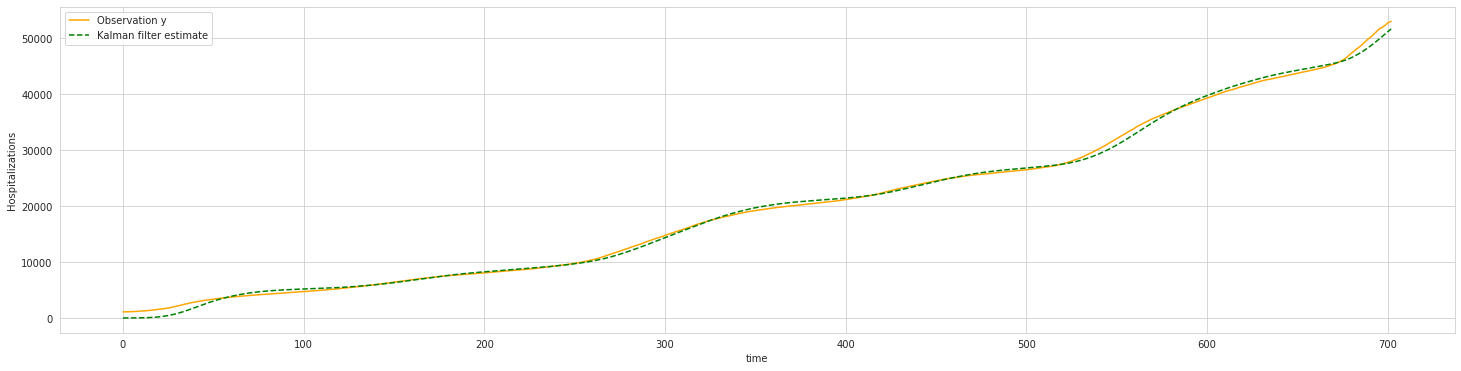

In [59]:
#Plot position
plt.figure(figsize = (25,6))
plt.plot(t,y, color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


Similarly to before, the Kalman Filter estimates are near the observed values, however there is noticeable error in the estimates before finding optimal estimated parameters.

Plot differences in y and Kalman filter estimate:

Text(0, 0.5, 'Residuals')

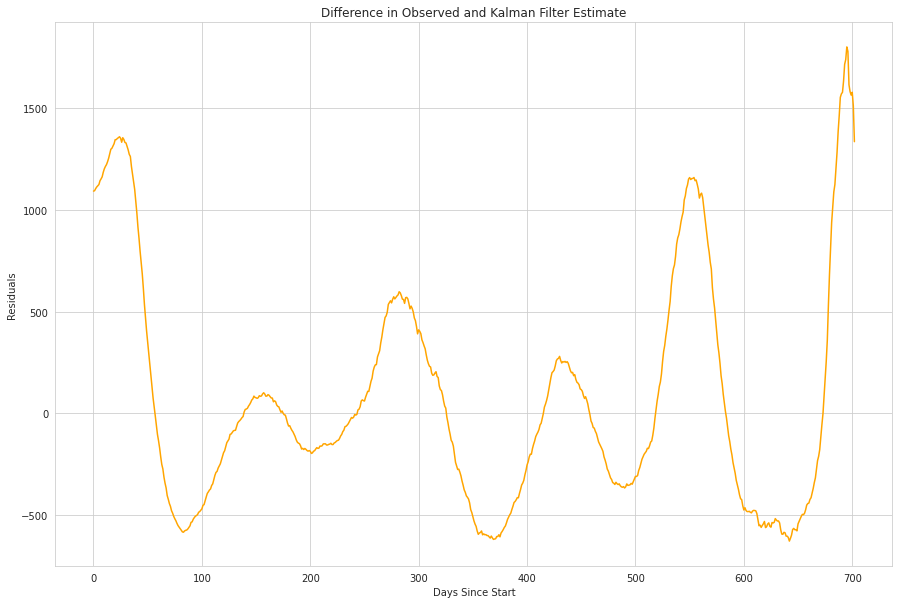

In [60]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

Again the errors are within 2000 hospitalizations, and we will attempt to imporve this by learning model parameters.

#### Learning model parameters

Suppose that we only have guesses for the noise covariances.

In [61]:
state_cov_matrix_guess = [[1000,0.0],[0.0,45]]

obs_std_guess = 2810.

We can define a `KalmanFilter` object with the guessed values and indicate that we want to use the EM algorithm to learn those parameters using `em_vars=['transition_covariance', 'observation_covariance']`

In [62]:
kf_learn = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix_guess, observation_covariance=obs_std_guess**2, transition_offsets=b.T, em_vars=['transition_covariance', 'observation_covariance'])

Applying the method `.em` uses the EM algorithm to estimate those parameters based on the observed data.

In [63]:
kf_learn = kf_learn.em(y, n_iter = 10)

Compare the learned values to the true values. This is a difficult optimization problem, so the estimates will not be perfect.

In [64]:
print('EM estimate of state covariance = ', kf_learn.transition_covariance, '. True covariance = ', state_cov_matrix)

EM estimate of state covariance =  [[1972.26953818  141.55708599]
 [ 141.55708599   59.57618908]] . True covariance =  [[1000, 0.0], [0.0, 45]]


In [65]:
print('EM estimate of observation variance = ', kf_learn.observation_covariance, '. True variance = ', obs_std**2)

EM estimate of observation variance =  [[3530.93376998]] . True variance =  7896100


#### Use Estimated values to Update Kalman Filter

Specify the parameters for the noise disturbance of the state. Assume a multivariate Gaussian distribution with zero mean.

In [66]:
#Vector of mean values 
state_mean_vec = [0.0, 0.0]

#Covariance matrix
state_cov_matrix = kf_learn.transition_covariance

Specify the parameters for the noise disturbance of the observation. Assume a Gaussian distribution with zero mean.

In [67]:
#mean value
obs_mean = 0.0

#standard deviation
obs_std = np.sqrt(kf_learn.observation_covariance)

#### Use the Kalman Filter to estimate the states with the estimated optimal model parameters

Define a Kalman filter object with the known properties of the system

In [68]:
kf = KalmanFilter(transition_matrices = A, observation_matrices = C, transition_covariance=state_cov_matrix, observation_covariance=obs_std**2, transition_offsets=b.T)

Perform Kalman filter estimation

In [69]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)

Plot the true states and the estimated values from the Kalman filter:

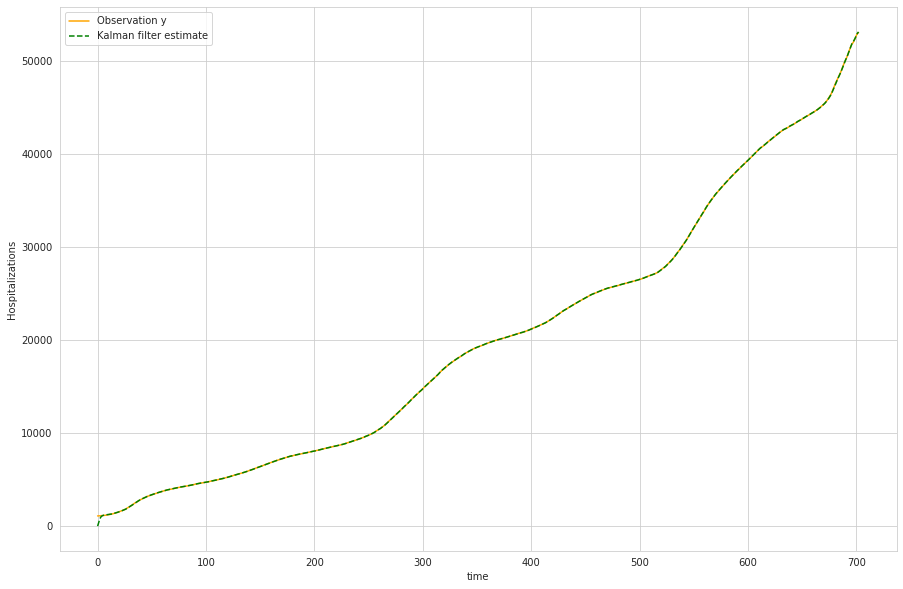

In [70]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y,color = 'orange')
plt.plot(t,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observation y', 'Kalman filter estimate'])


Like before, with the optimal estimated parameters, the Kalman filter estimates very quickly become near the observed values.

Plot differences in y and Kalman filter estimate:

Text(0, 0.5, 'Residuals')

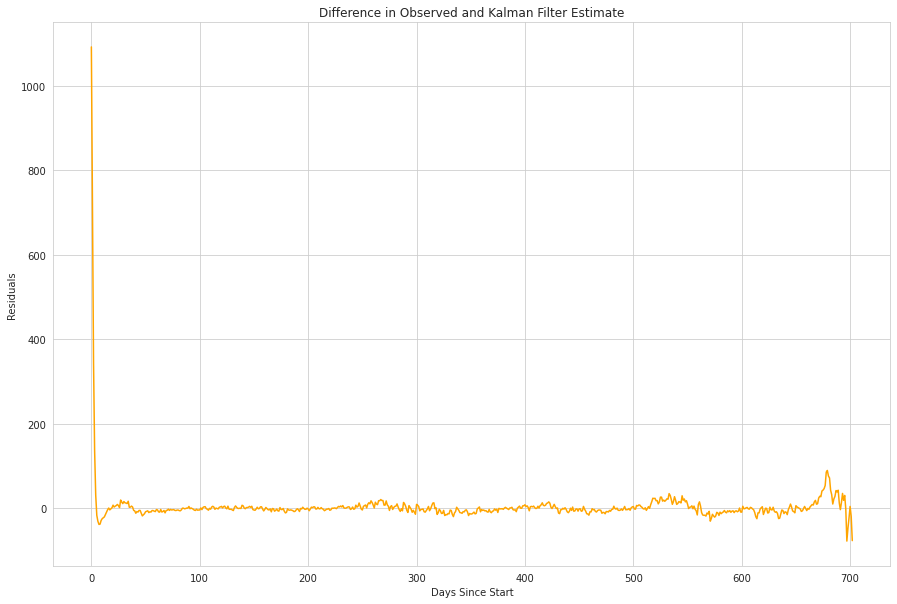

In [71]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')

Again, we see the errors quickly decrease with a relatively small spike towards the end.

Plot zoomed in on later values:

(-100.0, 100.0)

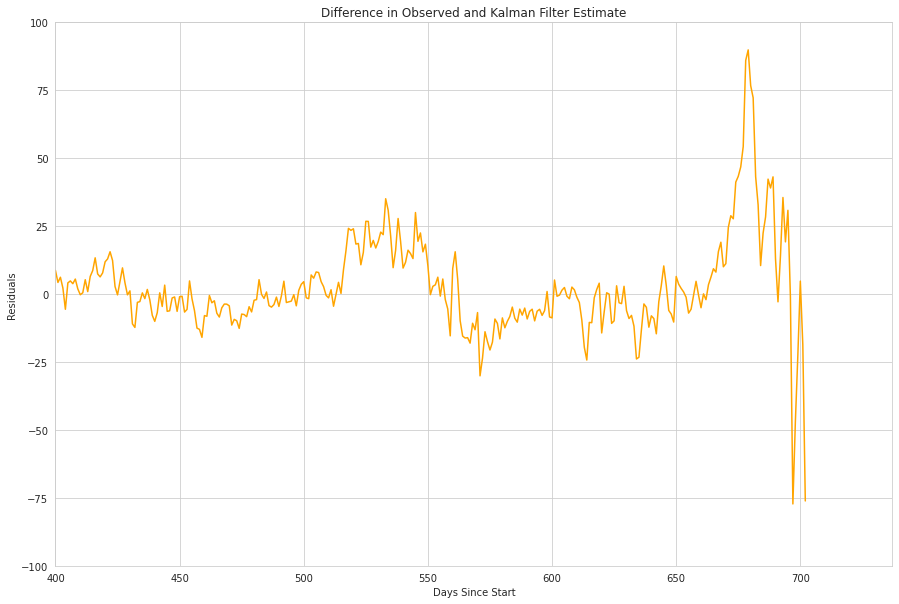

In [72]:
#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y - filtered_state_means[:,0],color = 'orange')
plt.title('Difference in Observed and Kalman Filter Estimate')
plt.xlabel('Days Since Start')
plt.ylabel('Residuals')
plt.xlim(400)
plt.ylim(ymin = -100, ymax =100)

Both models with and without the estimated control appear to estimate the states the same way. The estimated control signal does not appear to influence the model very much. 

#### Predict future values

Calculate predicted states for next 10 days.

In [73]:
for n in range(10):
  xhat_prev = filtered_state_means[-1]
  xhat_pred = np.matmul(A,xhat_prev) + b.T[-1]
  filtered_state_means = np.vstack((filtered_state_means, xhat_pred))

Plot the predictions for the next 10 days:

(52000.0, 56000.0)

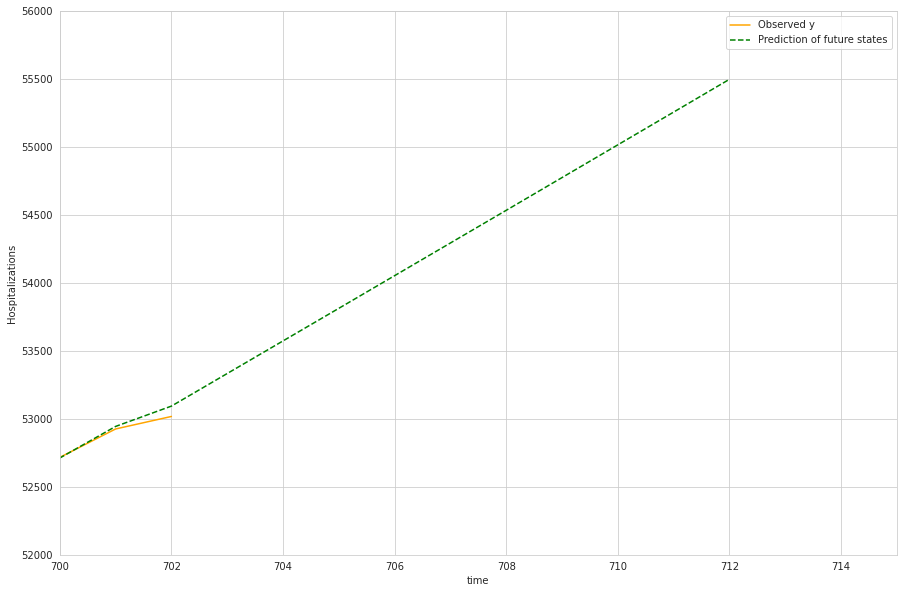

In [74]:
t_pred = np.arange(n_timesteps+10)*dt

#Plot position
plt.figure(figsize = (15,10))
plt.plot(t,y,color = 'orange')
plt.plot(t_pred,filtered_state_means[:,0], 'g--')

plt.xlabel('time')
plt.ylabel('Hospitalizations')
plt.legend(['Observed y','Prediction of future states'])
plt.xlim(xmin = 700, xmax = 715)
plt.ylim(ymin = 52000, ymax =56000)


The future predictions with a control signal are slightly higher than without, but again we should be cautious about extrapolating too much in the future.

# **$Conclusions$**

Overall, the Kalman Filter did an excellent job at modelling Hospitalizations due to COVID-19 in Washington State. It appears a simplified model without a control signal should be sufficient for modeling this relationship. While we can use the Kalman Filter to predict in the future, we should caution its use far into the future. Instead, updating the model with every new day's observation to predict the next day would be a better use of the model.